# Mathematical Underpinnings - Lab 7

In [152]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

## Task 1

### a)

In [153]:
def KL_mult_normal(mu1, mu2, Sigma1, Sigma2):
    # the formula is here: https://statproofbook.github.io/P/mvn-kl.html
    comp_1 = np.dot(mu2-mu1, np.dot(np.linalg.inv(Sigma2), mu2 - mu1))
    comp_2 = np.sum(np.diag(np.dot(np.linalg.inv(Sigma2), Sigma1)))
    comp_3 = np.log(np.linalg.det(Sigma1)/np.linalg.det(Sigma2))
    comp_4 = mu1.shape[0]
    return (comp_1 + comp_2 - comp_3 - comp_4) / 2

In [154]:
def T_opt(x, mu1, mu2, Sigma1, Sigma2):
    # compute log(p(x)/q(x)), where p and q are multivariate normal with parameters mu1, Sigma1 and mu2, Sigma2 respectively
    res = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        ft = -np.log(np.linalg.det(Sigma1)) / 2 - np.dot(np.dot(np.linalg.inv(Sigma1), (x[i,:] - mu1)), x[i,:] - mu1)/2
        st = np.log(np.linalg.det(Sigma2)) / 2 + np.dot(np.dot(np.linalg.inv(Sigma2), x[i,:] - mu2), x[i,:] - mu2)/2
        res[i] = ft+st
    return res

### b)

In [155]:
# sample n = 10000 observations out of np.random.multivariate_normal(mu1, Sigma1, size=n)
# and sample n = 10000 observations out of np.random.multivariate_normal(mu2, Sigma2, size=n)
# then concatenate the two matrices (your final x is a matrix 2n x 5)
# then create a vector y that will have n ones and n zeros (of size 2n)
np.random.seed(42)
n = 10000
mu1 = np.array([1, 1, 1, 0, 0])/5
mu2 = np.array([0, 0, 1, 1, 1])/5
Sigma1 = (np.eye(5)*9 + np.ones((5,5)))/10
Sigma2 = 1.2*np.eye(5) - np.ones((5,5))/5
x1 = np.random.multivariate_normal(mu1, Sigma1, size=n)
x2 = np.random.multivariate_normal(mu2, Sigma2, size=n)
x = np.concatenate((x1, x2), axis=0)
y = np.concatenate((1.0*np.ones(n), 0.0*np.zeros(n)))

In [156]:
def DV_fun(y, t):
    # y - an indicator [y[i]=1 if t[i] corresponds to x sampled from the distribution p, y[i]=0 otherwise]
    # t a vector (of the same length as y) t = log(p(x)/q(x))
    n1 = np.sum(y)
    n2 = np.sum(1 - y)
    return np.sum(t*y)/n1 - np.log(np.sum(np.exp(t)*(1-y))/n2)

In [157]:
KL_mult_normal(mu1, mu2, Sigma1, Sigma2)

2.169075737042572

In [158]:
DV_fun(y, T_opt(x, mu1, mu2, Sigma1, Sigma2))

2.339946807718526

### c)

In [159]:
def DV_loss(y_true, T_x):
    n1 = tf.math.reduce_sum(y_true)
    n2 = tf.math.reduce_sum(tf.subtract(tf.convert_to_tensor(1.0), y_true))
    first_term = tf.math.reduce_sum(tf.math.multiply(T_x, y_true))/n1
    second_term = tf.math.log(tf.math.reduce_sum(tf.math.multiply(tf.math.exp(T_x), tf.subtract(tf.convert_to_tensor(1.0), y_true)))/n2)
    return -(first_term - second_term) 

### d)

In [160]:
model_inputs = keras.Input(shape=(5))
layer_out = Dense(64, activation='softplus')(model_inputs)
#layer_out = Dense(125, activation='tanh')(layer_out)
layer_out = Dense(64)(layer_out)
model_outputs = Dense(1)(layer_out)
model = keras.Model(model_inputs, model_outputs)

optimizer = keras.optimizers.legacy.SGD(learning_rate=1e-2)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model.compile(optimizer=optimizer, loss=DV_loss)

In [161]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [162]:
hist = model.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test), callbacks=[es])

Epoch 1/100
15/15 [==============================] - 0s 8ms/step - loss: 0.0022 - val_loss: -0.0433
Epoch 2/100
15/15 [==============================] - 0s 3ms/step - loss: -0.0451 - val_loss: -0.0760
Epoch 3/100
15/15 [==============================] - 0s 3ms/step - loss: -0.0652 - val_loss: -0.0913
Epoch 4/100
15/15 [==============================] - 0s 3ms/step - loss: -0.0749 - val_loss: -0.0994
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: -0.0799 - val_loss: -0.1039
Epoch 6/100
15/15 [==============================] - 0s 3ms/step - loss: -0.0831 - val_loss: -0.1068
Epoch 7/100
15/15 [==============================] - 0s 3ms/step - loss: -0.0852 - val_loss: -0.1093
Epoch 8/100
15/15 [==============================] - 0s 3ms/step - loss: -0.0871 - val_loss: -0.1111
Epoch 9/100
15/15 [==============================] - 0s 4ms/step - loss: -0.0887 - val_loss: -0.1129
Epoch 10/100
15/15 [==============================] - 0s 3ms/step - loss: -0.0900 - val_loss

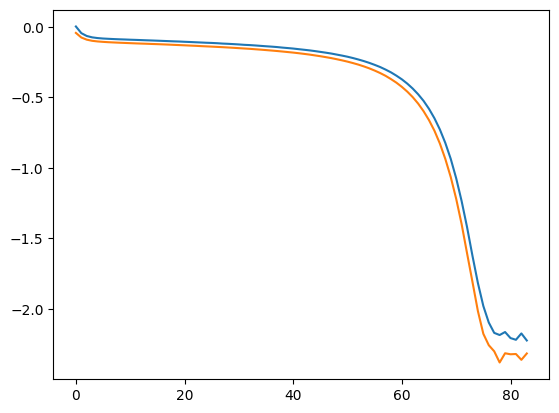

In [163]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

### e)

In [164]:
t_x_pred = model.predict(x)[:,0]

625/625 [==============================] - 0s 442us/step


In [165]:
t_x_opt = T_opt(x, mu1, mu2, Sigma1, Sigma2)

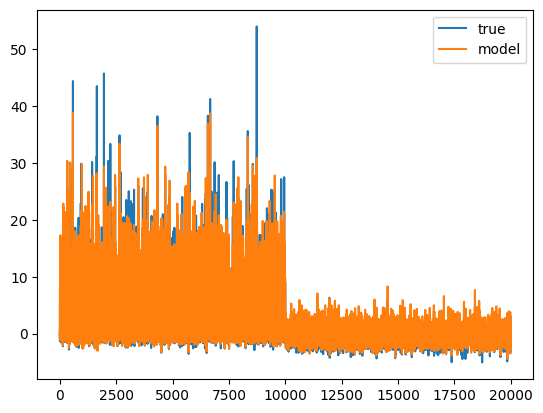

In [166]:
plt.plot(t_x_opt, label = 'true')
plt.plot(t_x_pred, label = 'model')
plt.legend()
plt.show()

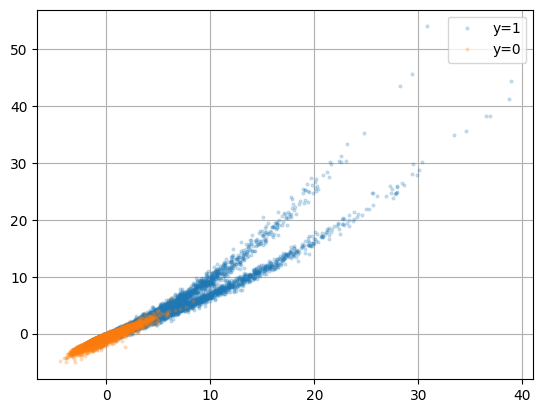

In [167]:
plt.plot(t_x_pred[y==1], t_x_opt[y==1], "o", alpha=0.2, markersize=2, label = 'y=1')
plt.plot(t_x_pred[y==0], t_x_opt[y==0], "o", alpha=0.2, markersize=2, label = 'y=0')
plt.grid()
plt.legend()
plt.show()

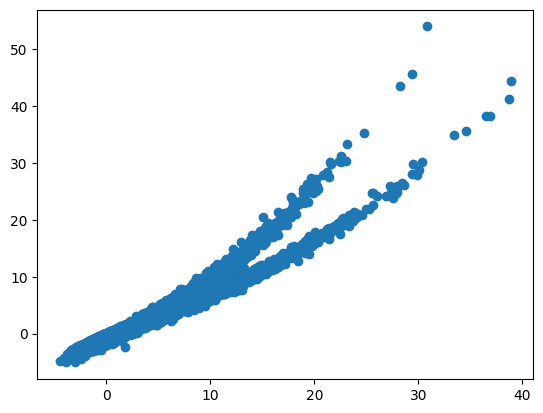

In [168]:
plt.plot(t_x_pred, t_x_opt, "o")
plt.show()

In [169]:
DV_fun(y, t_x_pred)

2.1198761799128594

In [170]:
DV_fun(y, t_x_opt)

2.339946807718526

In [171]:
# new data
n_new = 10000
x1 = np.random.multivariate_normal(mu1, Sigma1, size=n_new)
x2 = np.random.multivariate_normal(mu2, Sigma2, size=n_new)
x_new = np.concatenate((x1, x2), axis=0)
y_new = np.concatenate((1.0*np.ones(n_new), 0.0*np.zeros(n_new)))

In [172]:
t_x_pred = model.predict(x_new)
t_x_pred = t_x_pred[:,0]

625/625 [==============================] - 1s 936us/step


In [173]:
t_x_opt_new = T_opt(x_new, mu1, mu2, Sigma1, Sigma2)

In [174]:
DV_fun(y_new, t_x_pred)

1.9695243062986585

In [175]:
DV_fun(y_new, t_x_opt_new)

2.3062762975810776

### f)

In [176]:
def NWJ_loss(y_true, y_pred):
    first_term = tf.math.reduce_mean(y_pred[y_true == 1])
    second_term = tf.math.reduce_mean(tf.math.exp(y_pred[y_true == 0]-1))
    return -(first_term - second_term)

In [177]:
def NWJ_fun(y, t):
    # y - an indicator [y[i]=1 if t[i] corresponds to x sampled from the distribution p, y[i]=0 otherwise]
    # t a vector (of the same length as y) t = log(p(x)/q(x)) + 1
    return np.mean(t[y == 1]) - np.mean(np.exp(t[y == 0] - 1))

In [178]:
NWJ_fun(y, t_x_opt + 1)

2.3371830913447598

In [179]:
model_inputs = keras.Input(shape=(5))
layer_out = Dense(64, activation='softplus')(model_inputs)
# layer_out = Dense(125, activation='tanh')(layer_out)
# layer_out = Dense(64)(layer_out)
model_outputs = Dense(1)(layer_out)
model = keras.Model(model_inputs, model_outputs)

optimizer = keras.optimizers.legacy.Adam(learning_rate=1e-3)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model.compile(optimizer=optimizer, loss = NWJ_loss)

In [180]:
hist = model.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test), callbacks=[es])

Epoch 1/100
15/15 [==============================] - 0s 10ms/step - loss: 0.1757 - val_loss: -0.0275
Epoch 2/100
15/15 [==============================] - 0s 3ms/step - loss: -0.0339 - val_loss: -0.0539
Epoch 3/100
15/15 [==============================] - 0s 2ms/step - loss: -0.0499 - val_loss: -0.0784
Epoch 4/100
15/15 [==============================] - 0s 2ms/step - loss: -0.0654 - val_loss: -0.0895
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: -0.0715 - val_loss: -0.0955
Epoch 6/100
15/15 [==============================] - 0s 3ms/step - loss: -0.0774 - val_loss: -0.1009
Epoch 7/100
15/15 [==============================] - 0s 3ms/step - loss: -0.0836 - val_loss: -0.1074
Epoch 8/100
15/15 [==============================] - 0s 3ms/step - loss: -0.0897 - val_loss: -0.1137
Epoch 9/100
15/15 [==============================] - 0s 4ms/step - loss: -0.0969 - val_loss: -0.1213
Epoch 10/100
15/15 [==============================] - 0s 4ms/step - loss: -0.1047 - val_los

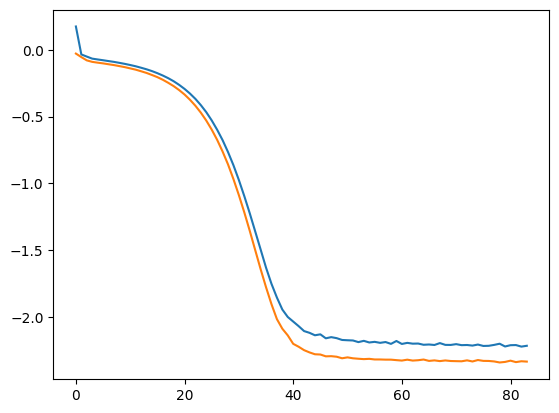

In [181]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

In [182]:
t_x_nwj = model.predict(x)
t_x_nwj_new = model.predict(x_new)
NWJ_fun(y, t_x_nwj), NWJ_fun(y_new, t_x_nwj_new)

625/625 [==============================] - 0s 381us/step


(2.2565112, 2.1249962)

In [183]:
KL_mult_normal(mu1, mu2, Sigma1, Sigma2), NWJ_fun(y, t_x_opt + 1), NWJ_fun(y, t_x_nwj)

(2.169075737042572, 2.3371830913447598, 2.2565112)

In [184]:
KL_mult_normal(mu1, mu2, Sigma1, Sigma2), NWJ_fun(y_new, t_x_opt_new + 1), NWJ_fun(y_new, t_x_nwj_new)

(2.169075737042572, 2.2935269587277354, 2.1249962)